# 제 3고지 : 고차 미분 계산
> 고차 미분이란 어떤 함수를 2번 이상 미분한 것을 말한다.

In [1]:
import sys
sys.path.append('..')

from dezero import Variable
from dezero.utils import *
from tools import plot_2dfunc
import dezero.functions as F

import numpy as np
import matplotlib.pyplot as plt

## step26 : 계산 그래프 시각화(2)

##### get_dot_graph, plot_dot_graph 외의 함수는 로컬에서만 사용 가능(_가 맨 앞에 옴)하므로 utils.py에 사용 예시를 구현했다

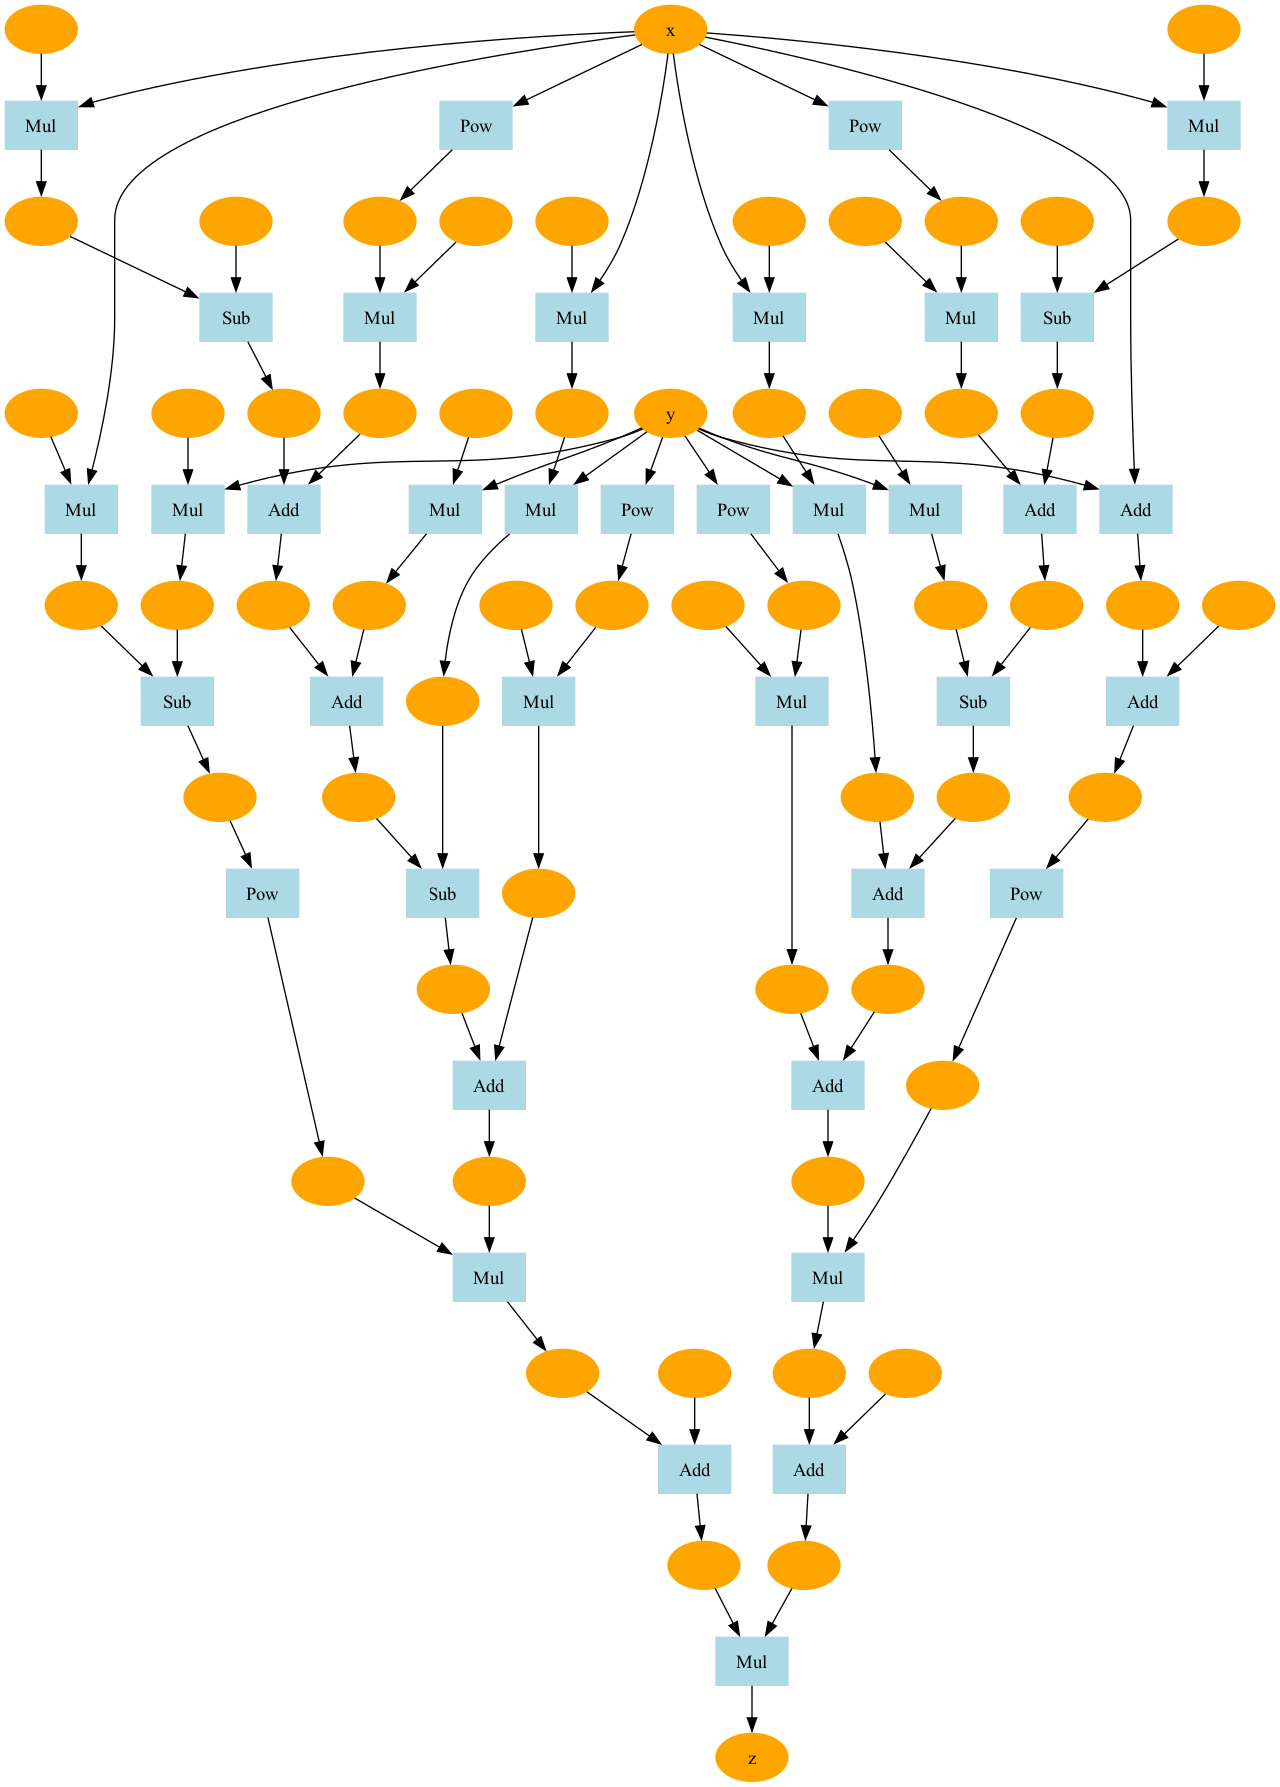

In [2]:
from main import goldstein

x = Variable(np.array(1.0))
y = Variable(np.array(1.0))
z = goldstein(x, y)
z.backward()

x.name = "x"
y.name = "y"
z.name = "z"
plot_dot_graph(z, verbose=False, to_file='compute_graph/goldstein.png')

#### 홈 디렉터리의 사용자 폴더에 저장된다. 폴더 앞에 .이 붙어서 숨겨져있으므로 "command + shift + . "을 사용해 볼 수 있다.

## step27 : 테일러 급수 미분

0.7071067811865475
variable(0.7071067811865475)


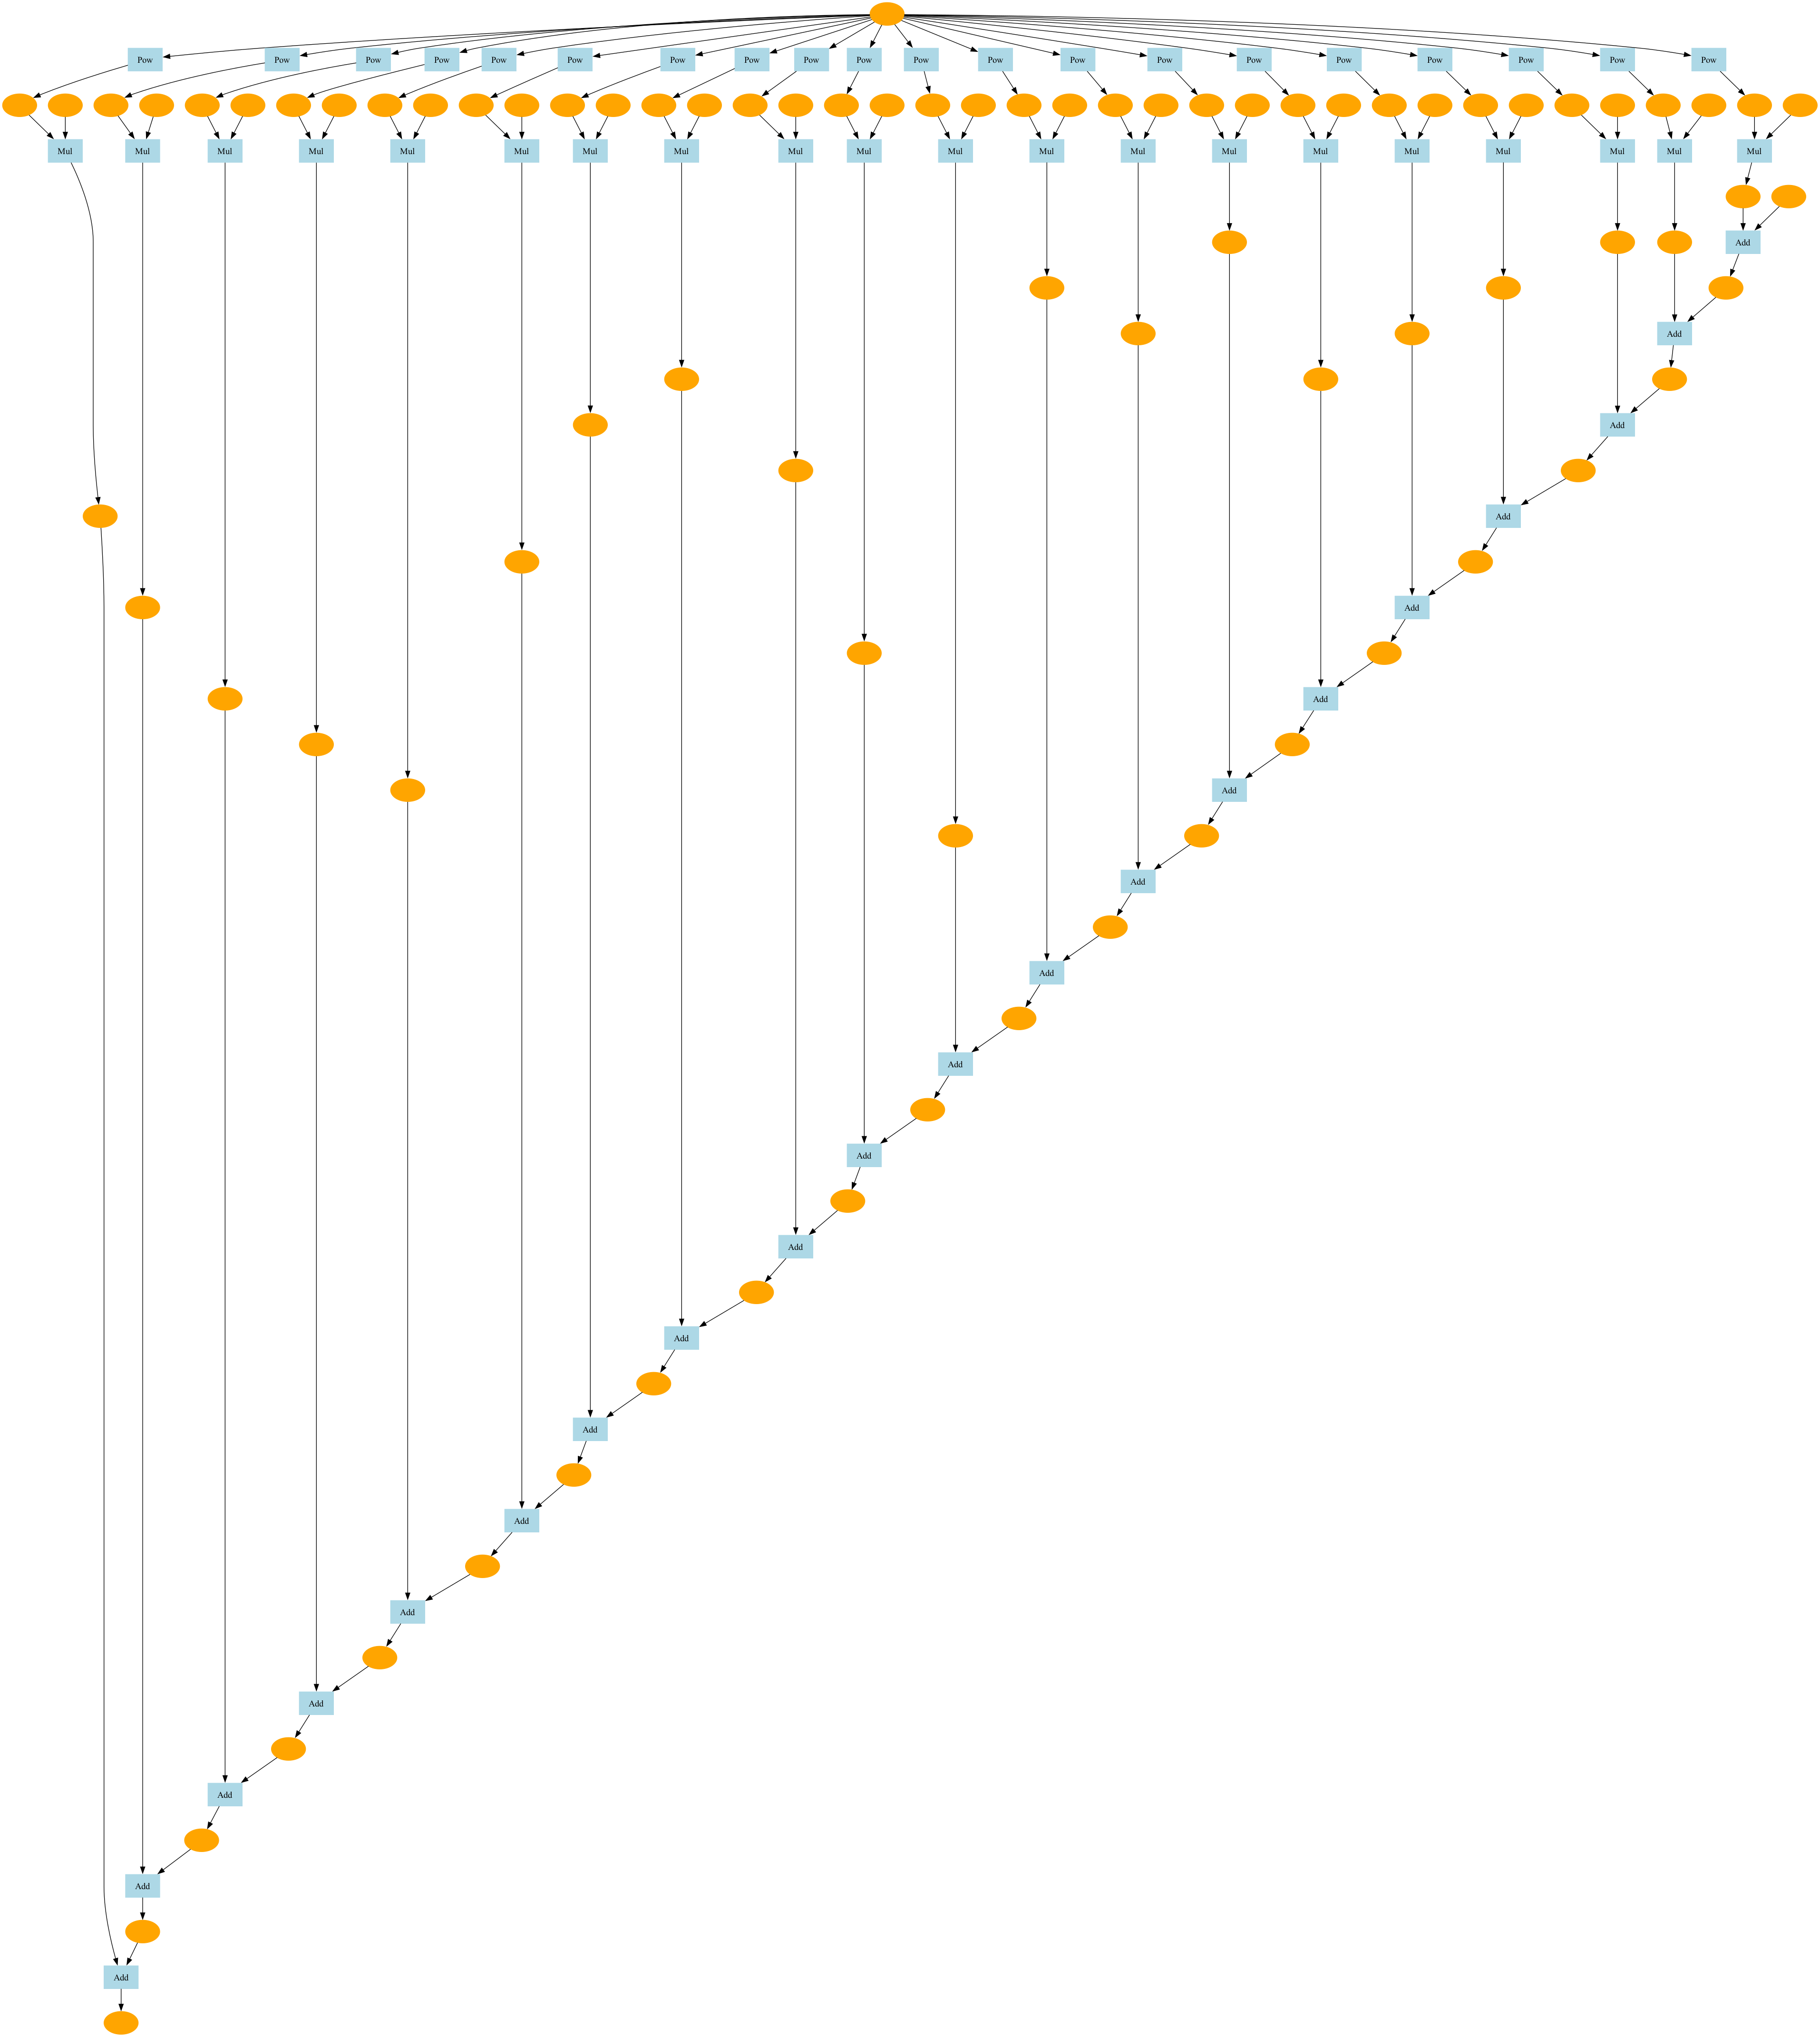

In [3]:
from main import my_sin

x = Variable(np.array(np.pi/4))
y = my_sin(x, 1e-50)
y.backward()

print(y.data)
print(x.grad)

plot_dot_graph(y, verbose=False, to_file='compute_graph/my_sin.png')

## step28 : 함수 최적화
> 최적화란 어떤 함수가 주어졌을 때 그 최솟값(또는 최대값)을 반환하는 '입력(함수의 인수)'를 찾는 일이다.

In [4]:
from main import rosenbrock     # 로젠브록 함수 : Rosenbrock function

x0 = Variable(np.array(0.0))
x1 = Variable(np.array(2.0))

y = rosenbrock(x0, x1)
y.backward()
print(x0.grad, x1.grad)         # (-2.0, 400.0) : 기울기 벡터, 함수의 출력을 가장 크게 하는 방향

variable(-2.0) variable(400.0)


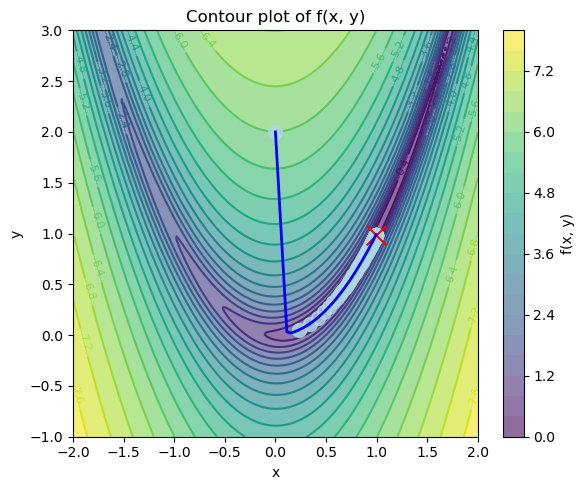

In [ ]:
x0 = Variable(np.array(0.0))
x1 = Variable(np.array(2.0))

lr = 0.001
iters = 10000

history = []

for i in range(iters):
    if i % 20 == 0:
        history.append([float(x0.data.copy()), float(x1.data.copy())])

    y = rosenbrock(x0, x1)

    x0.cleargrad()      # self.grad = None
    x1.cleargrad()
    y.backward()
    
    x0.data -= lr * x0.grad.data        # step32    / grad의 데이터타입 변경으로 생긴 오류 수정 : x0.grad -> x0,grad.data
    x1.data -= lr * x1.grad.data


plot_2dfunc(rosenbrock, [-2, 2], [-1, 3], line=history, line_name="rosenbrock", dot=True)

## step29 : 뉴턴 방법으로 푸는 최적화(수동 계산)
> 함수의 테일러급수 형태에서 기울기를 구한다. 즉, 원 함수의 기울기 대신 근사 함수의 기울기를 사용한다.      

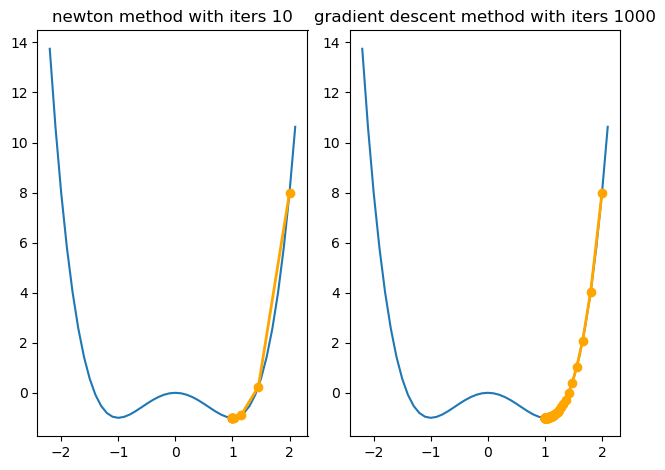

In [8]:
from main import newton_f, newton_gx2

x = Variable(np.array(2.0))
iters_newton = 10
history_newton = []

for i in range(iters_newton):
    y = newton_f(x)
    x.cleargrad()
    y.backward()

    history_newton.append([x.data.copy(), y.data])

    x.data -= x.grad.data / newton_gx2(x.data)           # 2차 미분 미구현이므로 따로 함수를 만들어줌

x = Variable(np.array(2.0))
iters_gd = 1000
lr = 0.001
history_gd = []

for i in range(iters_gd):
    y = newton_f(x)
    x.cleargrad()
    y.backward()

    if i % 10 == 0:
        history_gd.append([x.data.copy(), y.data])

    x.data -= lr * x.grad.data

history_newton = np.array(history_newton)
history_gd = np.array(history_gd)

X = np.arange(-2.2, 2.2, 0.1)
Y = newton_f(X)    

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(X, Y)
ax1.plot(history_newton[:, 0], history_newton[:, 1], marker='o', color="orange", linewidth=2, zorder=20)
ax1.set_title(f'newton method with iters {iters_newton}')

ax2.plot(X, Y)
ax2.plot(history_gd[:, 0], history_gd[:, 1], marker='o', color='orange', linewidth=2, zorder=20)
ax2.set_title(f'gradient descent method with iters {iters_gd}')

plt.tight_layout()
plt.show()

## step32 : 고차 미분(구현 편)
> core_simple.py를 끝내고 core.py 시작

#### 기존의 역전파는 1차 미분($\frac{\partial L}{\partial x}$)만을 지원했다. 이번 단계의 변경으로 dezero는 2차 미분($\frac{\partial^2 L}{\partial x^2}$)이상을 지원한다.

## step33 : 뉴턴 방법으로 푸는 최적화(자동 계산)
> 29단계에서 진행한 코드를 기반으로 진행

In [9]:
x = Variable(np.array(2.0))
iters = 10

for i in range(iters):
    print(i, x)

    y = newton_f(x)
    x.cleargrad()
    y.backward(create_graph=True)
    gx = x.grad
    x.cleargrad()
    gx.backward()
    gx2 = x.grad

    x.data -= gx.data / gx2.data

0 variable(2.0)
1 variable(1.4545454545454546)
2 variable(1.1510467893775467)
3 variable(1.0253259289766978)
4 variable(1.0009084519430513)
5 variable(1.0000012353089454)
6 variable(1.000000000002289)
7 variable(1.0)
8 variable(1.0)
9 variable(1.0)


## step34 : sin 함수 고차 미분
> dezero/functions.py

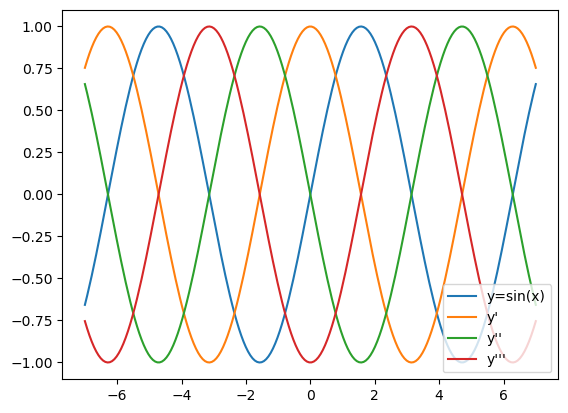

In [13]:
x = Variable(np.linspace(-7, 7, 200))
y = F.sin(x)
y.backward(create_graph=True)

logs = [y.data]

for i in range(3):
    logs.append(x.grad.data)
    gx = x.grad
    x.cleargrad()
    gx.backward(create_graph=True)

# 그래프 그리기
labels = ["y=sin(x)", "y'", "y''", "y'''"]
for i, v in enumerate(logs):
    plt.plot(x.data, logs[i], label=labels[i])
plt.legend(loc="lower right")
plt.show()